# Quantum Teleportation circuito

In [1]:
# No olvidar que en "Google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime ipywidgets
except ImportError:
    print("NOT in colab")

In colab, let's install things...
INFO: pip is looking at multiple versions of qiskit-aer to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.0

In [16]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
import scipy.linalg as la
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_bloch_multivector, array_to_latex, plot_state_qsphere

In [12]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    d_latex = psi.draw('latex', prefix=prefix)
    display(d_latex)
    #
    d_bloch = psi.draw('bloch')
    if isinstance(inches, (int,float)):
        if inches > 0:
            d_bloch.set_size_inches(inches, inches, forward=True)
            display(d_bloch)
    else:
        display(d_bloch)



Primero preparamos un estado $|\psi\rangle$ aleatorio.

<IPython.core.display.Latex object>

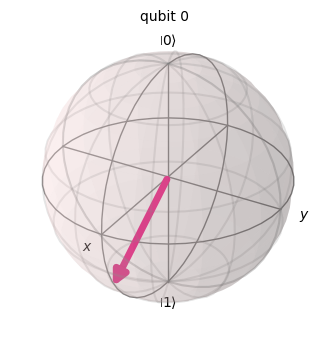

In [24]:
# Vamos a generar un vector de estado de un qubit a un estado aleatorio
rm = np.random.rand(2,1) + np.random.rand(2,1)*1j
rm = rm/la.norm(rm) # Normalizar
initial_state = Statevector(rm)

my_display_state_vector(initial_state, 4)

Nos construimos el circuito para hacer la teleportación cuántica.

Para ello usamos el par de Bell en $q_1,q_2$ que serían los que tuvieran Alice y Bob respectivamente.

Y queremos que al finalizar el circuito, el estado que estaba en $q_0$, el qubit de Alice, pase a estar en $q_2$, el qubit de Bob.

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


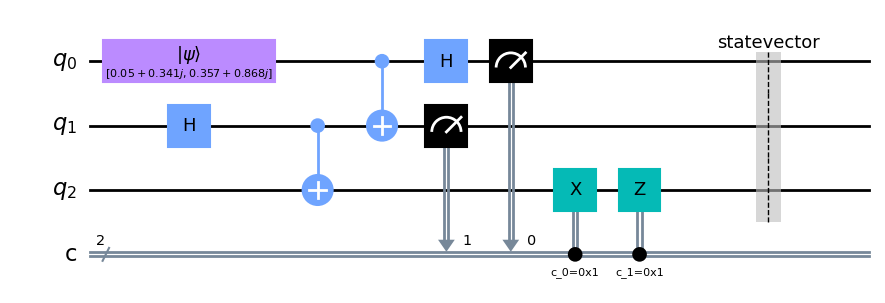

In [25]:

#Vamos a construirnos el estado de Bell 1/sqrt(2) ( |00> + |11>) para q1q2 y luego las mediciones q0q1

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)
# Inicializamos el primer qubit con el estado statevector random
circuit.initialize(initial_state,qreg_q[0])
# Construir el par entrelazado de bell
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
# Medicion del estado de Alice junto con su par de bell
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.x(qreg_q[2]).c_if(creg_c[0], 1)  # Aplicar puerta X al tercer qubit si medimos 1 en el primer qubit = '&1'
circuit.z(qreg_q[2]).c_if(creg_c[1], 1)  # Aplicar puerta Z al tercer qubit si medimos 1 en el segundo qubit = '1&'
circuit.save_statevector()
#
circuit.draw('mpl')


Comprobamos que el circuito funciona según lo previsto. Para ello vamos a usar un simulador de Qiskit y el statevector para poder sacar el estado final de $q_2$.

<IPython.core.display.Latex object>

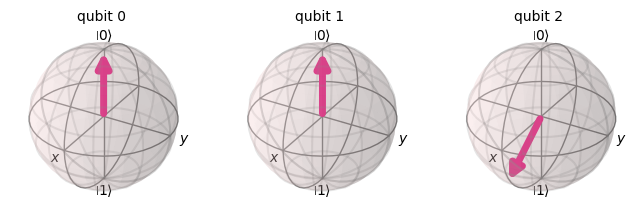

In [26]:
# Generamos una instancia del simulador;
# con "method" le especificamos el método de simulación
# Change the method to 'qasm_simulator' to get counts
simulador = AerSimulator(method='statevector')

# Transpilamos
circuit_t = transpile(circuit, backend=simulador)

# Ejecutamos la simulación, con un buen número de repeticiones
# (shots = 1000), ya que tenemos un medidor
job = simulador.run(circuit_t, shots=1)
result = job.result()
# con poderes podemos sacar el estado del qubit 2
final_state = result.get_statevector()
my_display_state_vector(final_state, 8)